In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import math
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.externals import joblib

In [2]:
def get_woe(column, dataframe, delayCol):
    column_to_woe = dataframe[column].copy()
    total_count = dataframe[column].value_counts()
    tot_loop = total_count.shape[0]
    p = np.float(dataframe[(delayCol) == 1].shape[0])
    n = dataframe.shape[0]-p
    i=0
    for item in total_count.iteritems():
        i+=1
        print('{0} of {1}\r'.format(i, tot_loop), end=''),
        pi = dataframe[(dataframe[column] == item[0]) & (delayCol)].shape[0]
        ni = np.float(item[1]-pi)
        if pi==0 or ni==0:
            WOE = float('nan')
        else:
            WOE = np.log((pi/p)/(ni/n))
            
        column_to_woe[column_to_woe == item[0]] = WOE
    print("get_woe() completed!")
    return column_to_woe.apply(pd.to_numeric)
    

data = pd.read_csv("cleaned_and_sampled_flights_v2.csv", low_memory=False)
print(data.shape)
display(data.head(5))

origin_woe = get_woe('ORIGIN_AIRPORT', data, data.ARRIVAL_DELAY_BIN_30)
data['ORIGIN_WOE_30'] = origin_woe
destination_woe = get_woe('DESTINATION_AIRPORT', data, data.ARRIVAL_DELAY_BIN_30)
data['DESTINATION_WOE_30'] = destination_woe
day_of_year_woe = get_woe('DAY_OF_YEAR', data, data.ARRIVAL_DELAY_BIN_30)
data['DAY_OF_YEAR_WOE_30'] = day_of_year_woe

data.to_csv('data_testing_random_forest.csv')

In [3]:
data = pd.read_csv('../data/data_testing_random_forest.csv')
data = data.dropna(axis=0, how='any')
y = data['ARRIVAL_DELAY_BIN_30']
X = data[['SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE','SCHEDULED_ARRIVAL', \
                  'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5','DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', \
                  'AIRLINE_AS', 'AIRLINE_B6','AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ', \
                  'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX','AIRLINE_WN',\
          'ORIGIN_WOE_30', 'DESTINATION_WOE_30', 'DAY_OF_YEAR_WOE_30']].copy()

display(X.head(5))
y = data.ARRIVAL_DELAY_BIN_30
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,...,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_WOE_30,DESTINATION_WOE_30,DAY_OF_YEAR_WOE_30
0,464.0,145.0,955,669.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,-0.177348,-0.003495,-0.586823
1,596.0,86.0,420,742.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0.166972,0.082505,0.258996
2,452.0,243.0,1535,575.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,-0.176318,0.133607,-0.778808
3,895.0,155.0,954,1050.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.066534,-0.250770,-0.042656
4,449.0,331.0,2556,960.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.943535,0.133607,0.388327


(382693, 26) (188491, 26) (382693,) (188491,)


In [4]:
#paramRF = {'max_depth':np.arange(1,50,5, None), 'class_weight':['balanced']}
#RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid=paramRF, \
#                             cv=2,scoring='accuracy', verbose=1)
RF_classifier = RandomForestClassifier(class_weight='balanced')
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

In [5]:
print(accuracy_score(y_pred,y_test))
print(f1_score(y_pred,y_test))
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred,y_test))
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.33, random_state=42)
print(X_train.shape)
print(1-np.sum(y_test)/np.float(y_test.shape[0]))

0.88137895178
0.0943740127182
             precision    recall  f1-score   support

          0       0.99      0.89      0.94    185275
          1       0.05      0.36      0.09      3216

avg / total       0.97      0.88      0.92    188491

[[164967  20308]
 [  2051   1165]]
(382693, 26)
0.886079441459


<built-in method mro of ABCMeta object at 0x1120128a8>


,features,label
15,0.001154,AIRLINE_HA
21,0.001908,AIRLINE_VX
14,0.002779,AIRLINE_F9
10,0.002993,AIRLINE_AS
17,0.003713,AIRLINE_NK


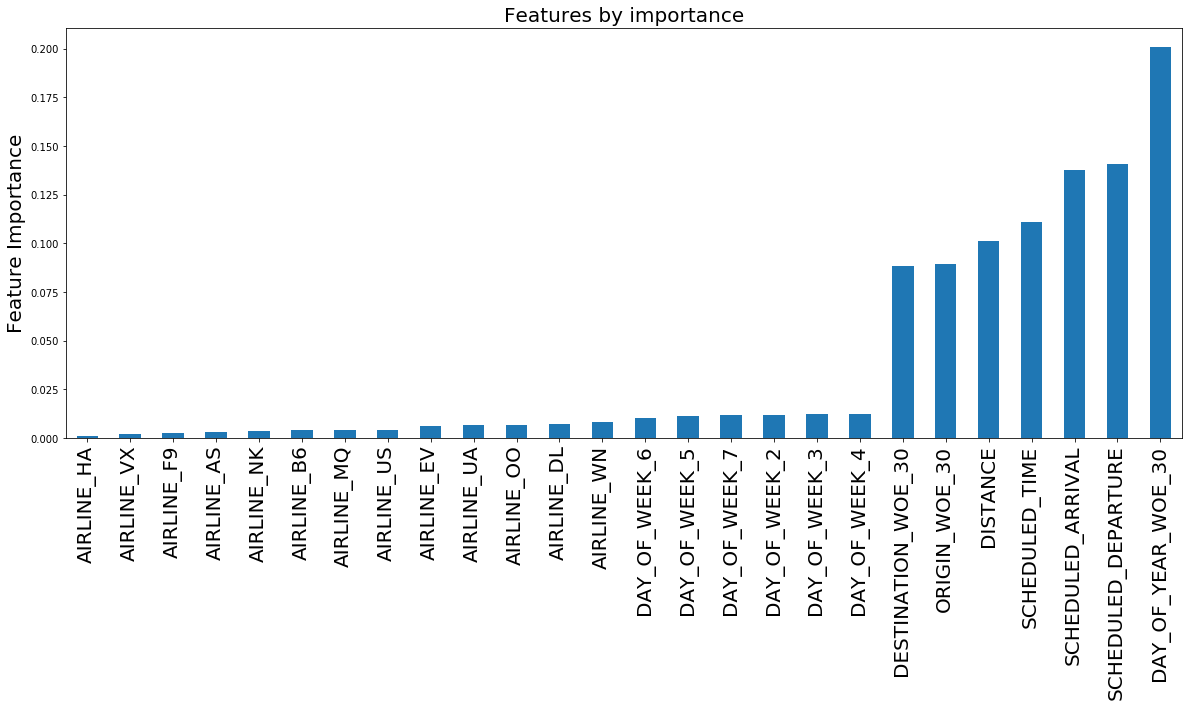

In [74]:
x_ax_lab = X_test.columns.values
rf_feat = RF_classifier.feature_importances_
all_dat = pd.DataFrame({'label':x_ax_lab, 'features':rf_feat})
all_dat = all_dat.sort_values('features')
#all_dat = all_dat.set_index('label')
print(RandomForestClassifier.mro)
display(all_dat.head(5))

ax = all_dat.plot(all_dat.label,kind='bar',legend=False,figsize=(20, 15),label=False)
fig = ax.get_figure()
fig.add_subplot(ax)
plt.xticks(rotation=90, fontsize=20)
#fig.tight_layout()
plt.title('Features by importance',fontsize=20)
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('')
plt.gcf().subplots_adjust(bottom=0.5)
fig.savefig('Feature Importance Random Forest.png')
plt.show()